# Solar Power Generation Forecast

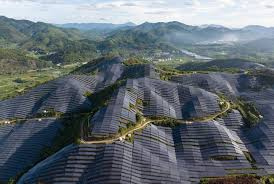

### Problem statement



In [47]:
%pip install numpy pandas matplotlib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [48]:
%pip install seaborn
from sklearn.preprocessing import StandardScaler # for feature scaling
from sklearn.model_selection import train_test_split # For splitting dataset into training and testing set
from sklearn.linear_model import LinearRegression # For Model Selection
from sklearn.ensemble import RandomForestRegressor # Model Selection for Random Forest
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # To Evaluate Model's Performance
from datetime import datetime  # To handle time based features 
import joblib # For saving and Loading the Trained Model

import numpy as np # To perform numerical operations
import pandas as pd # To do data manipulation and analysis
import matplotlib.pyplot as plt # For data visualization
import seaborn as sns # For advanced Data visualizations

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [49]:
#Loading the plant 1 generation and Weather Sensor Data
generation_data = pd.read_csv('Plant_1_Generation_Data.csv')
weather_data = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')


In [50]:
generation_data.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [51]:
generation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB


In [52]:
weather_data.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,15-05-2020 00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,15-05-2020 00:15,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,15-05-2020 00:30,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,15-05-2020 00:45,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,15-05-2020 01:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


In [53]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3182 non-null   object 
 1   PLANT_ID             3182 non-null   int64  
 2   SOURCE_KEY           3182 non-null   object 
 3   AMBIENT_TEMPERATURE  3182 non-null   float64
 4   MODULE_TEMPERATURE   3182 non-null   float64
 5   IRRADIATION          3182 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 149.3+ KB


### Merging data (Since both are having some common columns)

In [54]:
# before merging the datasets we need to convert date time format for proper time alignement

generation_data['DATE_TIME'] = pd.to_datetime(generation_data['DATE_TIME'], dayfirst=True) # Parsing the date string in the format of Day/month/year
weather_data['DATE_TIME'] = pd.to_datetime(weather_data['DATE_TIME'])
weather_data.head()


C:\Users\vaide\AppData\Local\Temp\ipykernel_22800\4004590208.py:4: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  weather_data['DATE_TIME'] = pd.to_datetime(weather_data['DATE_TIME'])


,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


### aggregation generation and weather sensor data

In [55]:
# Aggregating Generation Data
generation_agg = generation_data.groupby('DATE_TIME').agg({
    'DC_POWER':'sum', #calculating the sum of DC_Power
    'AC_POWER':'sum', #calculating the sum of AC_POWER
    'DAILY_YIELD' : 'mean', #calculating the average of DAILY_YEILD
    'TOTAL_YIELD' : 'mean' #calculating the average of TOTAL_YIELD
}).reset_index() # Used to control and manage the structure of a Dataframe's Index

In [56]:
generation_agg.describe()


,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,3158,3158.000000,3158.000000,3158.000000,3.158000e+03
mean,2020-06-01 06:42:44.344521728,68547.713729,6703.628149,3325.123773,6.977337e+06
min,2020-05-15 00:00:00,0.000000,0.000000,0.000000,6.635010e+06
25%,2020-05-23 23:18:45,0.000000,0.000000,4.125000,6.917337e+06
50%,2020-06-01 12:37:30,8515.285714,823.033036,3012.872159,6.981572e+06
75%,2020-06-09 17:56:15,140386.504463,13750.606696,6093.972403,7.045256e+06
max,2020-06-17 23:45:00,298937.785710,29150.212499,8807.727273,7.097398e+06
std,NaN,88044.612181,8603.120476,3045.079699,7.527885e+04


In [57]:
generation_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3158 entries, 0 to 3157
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATE_TIME    3158 non-null   datetime64[ns]
 1   DC_POWER     3158 non-null   float64       
 2   AC_POWER     3158 non-null   float64       
 3   DAILY_YIELD  3158 non-null   float64       
 4   TOTAL_YIELD  3158 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 123.5 KB


In [58]:
generation_data.describe()

,DATE_TIME,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,68778,68778.0,68778.000000,68778.000000,68778.000000,6.877800e+04
mean,2020-06-01 08:02:49.458256896,4135001.0,3147.426211,307.802752,3295.968737,6.978712e+06
min,2020-05-15 00:00:00,4135001.0,0.000000,0.000000,0.000000,6.183645e+06
25%,2020-05-24 00:45:00,4135001.0,0.000000,0.000000,0.000000,6.512003e+06
50%,2020-06-01 14:30:00,4135001.0,429.000000,41.493750,2658.714286,7.146685e+06
75%,2020-06-09 20:00:00,4135001.0,6366.964286,623.618750,6274.000000,7.268706e+06
max,2020-06-17 23:45:00,4135001.0,14471.125000,1410.950000,9163.000000,7.846821e+06
std,NaN,0.0,4036.457169,394.396439,3145.178309,4.162720e+05


In [59]:
generation_data.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [60]:
# aggregating Weather Sensor Data
weather_agg = weather_data.groupby('DATE_TIME').agg({
    'AMBIENT_TEMPERATURE' : 'mean', #calculating average AMBIENT_TEMPERATURE
    'MODULE_TEMPERATURE' : 'mean', #calculating average MODULE_TEMPERATURE
    'IRRADIATION' : 'mean' #calculating average IRRADIATION
}).reset_index()


In [61]:
weather_agg.describe()

,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,3182,3182.000000,3182.000000,3182.000000
mean,2020-06-01 05:52:22.080452608,25.531606,31.091015,0.228313
min,2020-05-15 00:00:00,20.398505,18.140415,0.000000
25%,2020-05-23 22:48:45,22.705182,21.090553,0.000000
50%,2020-06-01 09:52:30,24.613814,24.618060,0.024653
75%,2020-06-09 16:56:15,27.920532,41.307840,0.449588
max,2020-06-17 23:45:00,35.252486,65.545714,1.221652
std,NaN,3.354856,12.261222,0.300836


In [62]:
weather_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            3182 non-null   datetime64[ns]
 1   AMBIENT_TEMPERATURE  3182 non-null   float64       
 2   MODULE_TEMPERATURE   3182 non-null   float64       
 3   IRRADIATION          3182 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 99.6 KB


### Merging data

In [63]:
Final_Data = pd.merge(generation_agg,weather_agg,on='DATE_TIME',how='inner') #how carries other values like outer, left and right

In [64]:
Final_Data

,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,0.0,0.0,0.000000,6.837223e+06,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,0.0,0.0,0.000000,6.837223e+06,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,0.0,0.0,0.000000,6.837223e+06,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,0.0,0.0,0.000000,6.837223e+06,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,0.0,0.0,0.000000,6.852802e+06,24.621525,22.165423,0.0
...,...,...,...,...,...,...,...,...
3152,2020-06-17 22:45:00,0.0,0.0,5889.590909,7.097398e+06,22.150570,21.480377,0.0
3153,2020-06-17 23:00:00,0.0,0.0,5889.590909,7.097398e+06,22.129816,21.389024,0.0
3154,2020-06-17 23:15:00,0.0,0.0,5889.590909,7.097398e+06,22.008275,20.709211,0.0
3155,2020-06-17 23:30:00,0.0,0.0,5889.590909,7.097398e+06,21.969495,20.734963,0.0


In [65]:
# Savind the Merged Dataset
Final_Data.to_csv('Plant1_Merged_Dataset.csv',index=False)

In [66]:
Final_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3157 entries, 0 to 3156
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            3157 non-null   datetime64[ns]
 1   DC_POWER             3157 non-null   float64       
 2   AC_POWER             3157 non-null   float64       
 3   DAILY_YIELD          3157 non-null   float64       
 4   TOTAL_YIELD          3157 non-null   float64       
 5   AMBIENT_TEMPERATURE  3157 non-null   float64       
 6   MODULE_TEMPERATURE   3157 non-null   float64       
 7   IRRADIATION          3157 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 197.4 KB


In [67]:
Final_Data.describe()

,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,3157,3157.000000,3157.000000,3157.000000,3.157000e+03,3157.000000,3157.000000,3157.000000
mean,2020-06-01 06:41:41.298701568,68560.019625,6704.830534,3324.402716,6.977422e+06,25.560257,31.175453,0.230103
min,2020-05-15 00:00:00,0.000000,0.000000,0.000000,6.635010e+06,20.398505,18.140415,0.000000
25%,2020-05-23 23:15:00,0.000000,0.000000,4.124188,6.917337e+06,22.739895,21.130249,0.000000
50%,2020-06-01 12:30:00,8430.196429,814.880357,3009.619318,6.981686e+06,24.680324,24.801971,0.027748
75%,2020-06-09 18:00:00,140409.892856,13752.112500,6094.517045,7.045256e+06,27.941221,41.449481,0.451576
max,2020-06-17 23:45:00,298937.785710,29150.212499,8807.727273,7.097398e+06,35.252486,65.545714,1.221652
std,NaN,88055.843520,8604.217954,3045.292432,7.513782e+04,3.351059,12.272685,0.301348


In [68]:
# exploring null values
Final_Data.isnull().sum()

DATE_TIME              0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64

### Bining

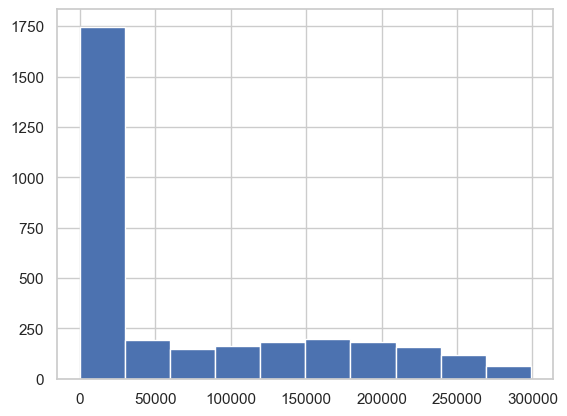

In [69]:
## Histogram for DC_POWER
plt.hist(Final_Data["DC_POWER"])
plt.show()

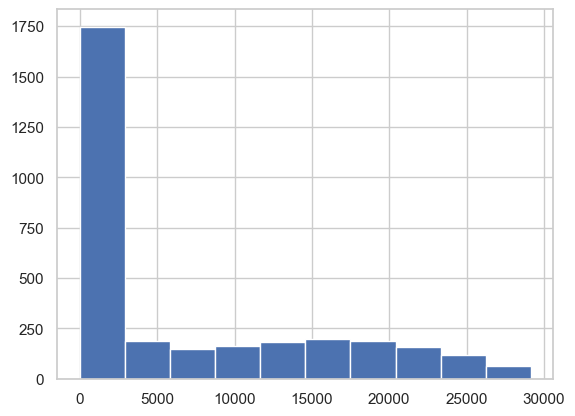

In [70]:
## Histogram for AC_POWER
plt.hist(Final_Data["AC_POWER"])
plt.show()

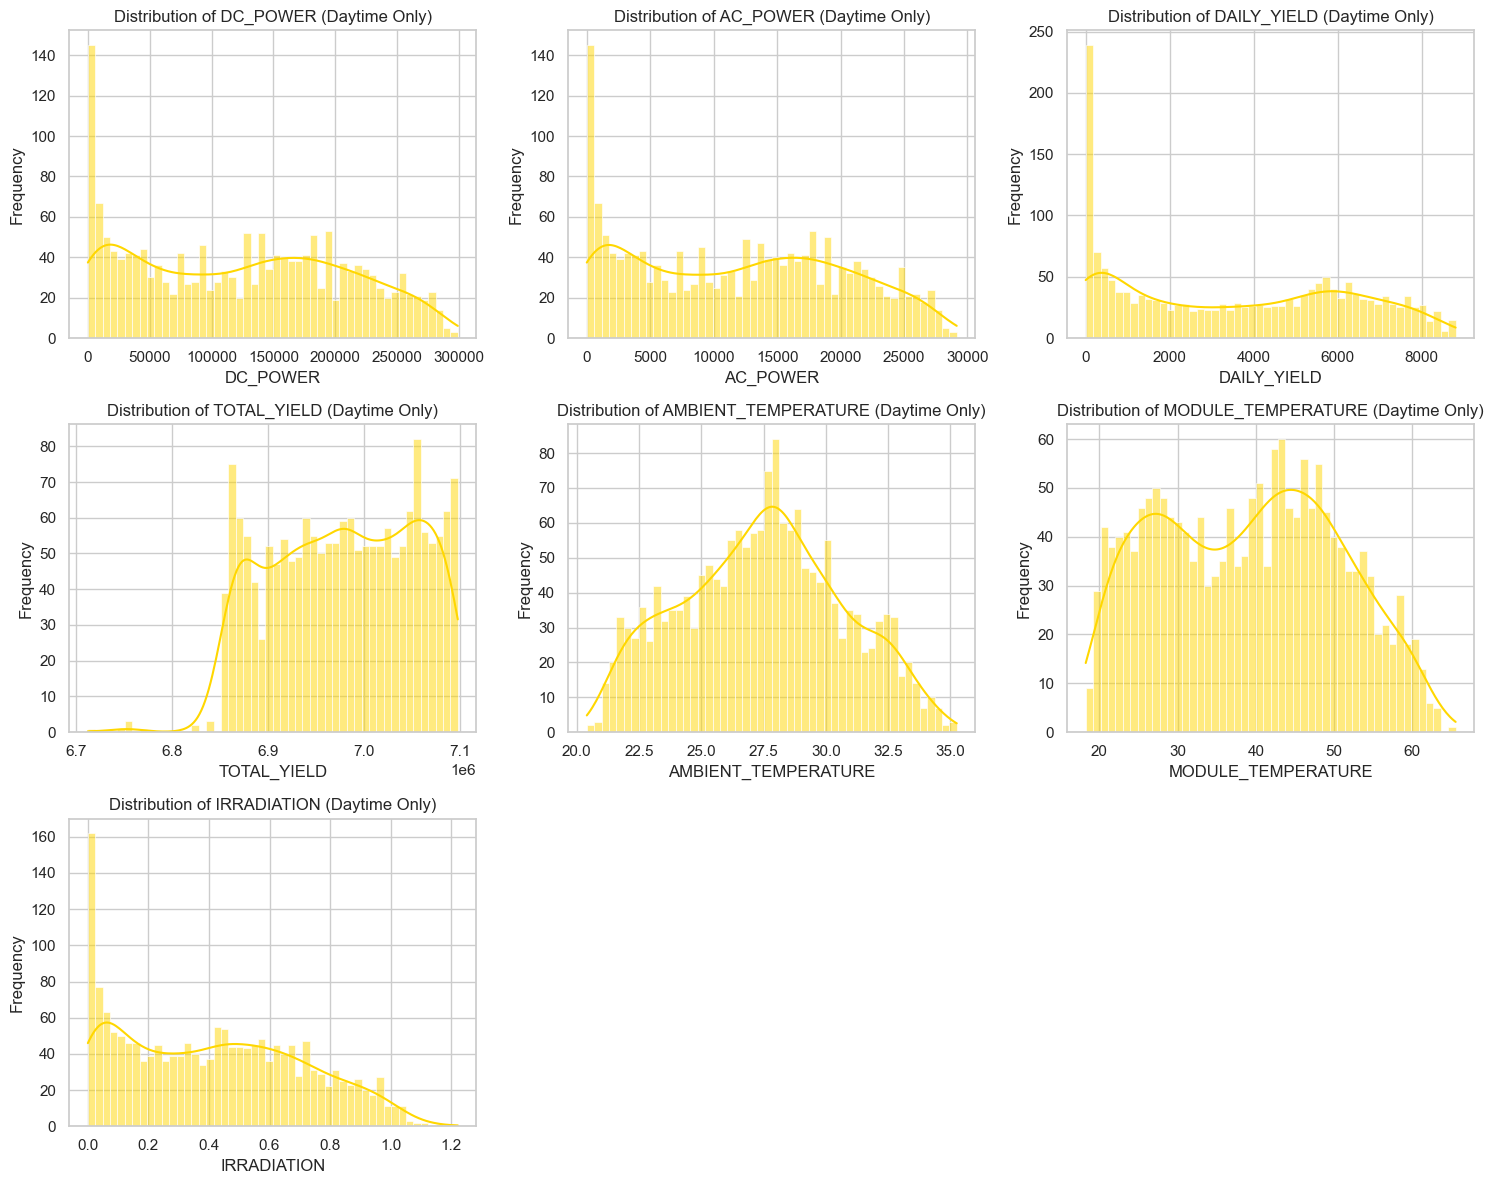

In [71]:
daytime_data = Final_Data[Final_Data['IRRADIATION']>0] # filtering only the day time data by setting Irridation > 0

numeric_columns = daytime_data.select_dtypes(include=['float64', 'int64']).columns # selecting only numeric columns from the dataframe

sns.set(style="whitegrid")

plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(daytime_data[col], kde=True, bins=50, color='gold')
    plt.title(f'Distribution of {col} (Daytime Only)')
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


### SUMMARY

1. Distribution of DC_POWER

📈 Observation: Most values are concentrated at the lower and mid ranges, with a decline at the high end.

🧠 Meaning: DC power output peaks during midday but remains low in early morning and late afternoon, causing a skew toward the lower end.

⚡ Insight: This is typical of solar production — bell-like shape with fewer high-power periods.

2. Distribution of AC_POWER

📈 Observation: Similar pattern to DC power but with slightly lower magnitude (since AC is converted from DC).

🧠 Meaning: Inverters convert DC to AC with some efficiency loss. So, AC power is expected to follow the DC distribution closely but be slightly lower.

⚡ Insight: The shape reflects inverter efficiency and daytime production behavior.

3. Distribution of DAILY_YIELD

📈 Observation: A peak in lower yield range, followed by a flatter curve.

🧠 Meaning: Daily yield represents cumulative energy over the day, so low yields may occur on cloudy or short daylight days.

⚡ Insight: Most days have moderate to low energy output, with fewer high-production days (e.g., clear sunny days).

4. Distribution of TOTAL_YIELD

📈 Observation: Values are concentrated in a very narrow range (around 6.8–7.1 million), with slight increase at the upper end.

🧠 Meaning: Total yield is cumulative over the lifetime of the system — so it only increases, never decreases.

⚡ Insight: This plot essentially reflects how often certain cumulative totals were recorded. It shows steady growth over time.

5. Distribution of AMBIENT_TEMPERATURE

📈 Observation: Peaks around 27–30 °C, with lower frequencies below 22 °C or above 33 °C.

🧠 Meaning: Most daytime ambient temperatures fall in a typical warm range.

⚡ Insight: This aligns with warm climate regions, especially in sunny hours when production is active.

6. Distribution of MODULE_TEMPERATURE

📈 Observation: Bimodal pattern with peaks between 30–40 °C and 45–55 °C.

🧠 Meaning: Module temperature rises above ambient due to solar irradiation. Two peaks suggest different operational states — possibly morning vs noon or different seasonal behavior.

⚡ Insight: High module temperatures can slightly reduce panel efficiency.

7. Distribution of IRRADIATION

📈 Observation: High frequency at low irradiation levels and a gradual decline toward higher levels.

🧠 Meaning: Early and late daylight hours have low irradiation; only a small fraction of the day has peak sunlight.

⚡ Insight: Solar power plants spend more time at low-to-moderate irradiation than at peak levels.

**A short summary From the above Feature Distribution**
* **DC_POWER & AC_POWER** : Both show right-skewed distributions, indicating most readings are at lower power levels with fewer high-output instances.
* **DAILY_YEILD** : Right-skewed distribution suggests many days with lower energy production, potentially due to shorter daylight hours or cloudy weather conditions.
* **TOTAL_YEILD** : Displays a narrow range with a nearly uniform spread.
* **AMBIENT_TEMPERATURE** : Approximately normal distribution centered around 27–28°C.
* **MODULE_TEMPERATURE** : Bimodal distribution shows distinct heating patterns
* **IRRADIATION** : Strongly right-skewed, with a high frequency of low values.


### Plotting feature distribution

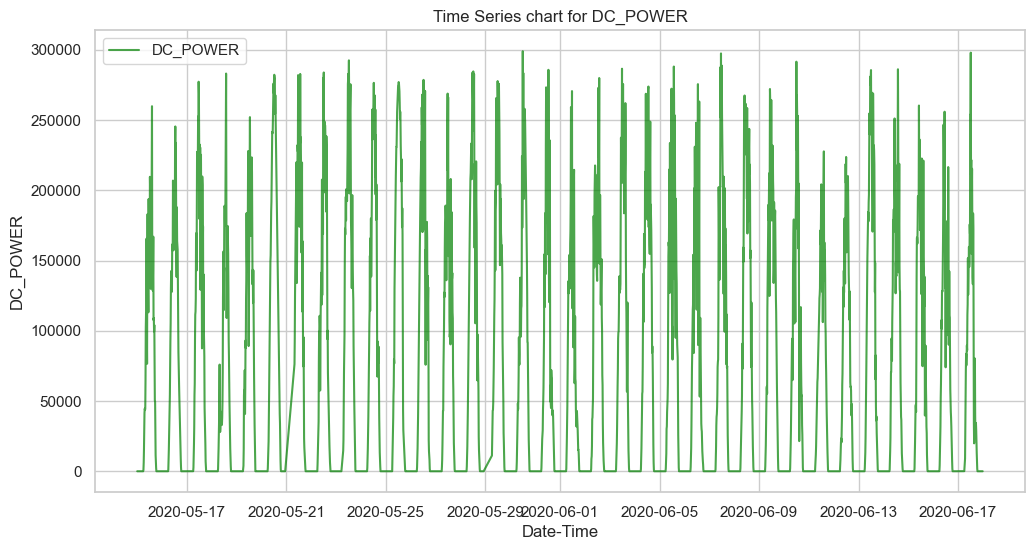

In [72]:
# Set DATE_TIME as the index
Final_Data.set_index('DATE_TIME', inplace=True)
Final_Data.sort_index(inplace=True)

# Plot DC_POWER time series
plt.figure(figsize=(12, 6))
plt.plot(Final_Data.index, Final_Data['DC_POWER'], color="green", alpha=0.7, label="DC_POWER")

plt.title("Time Series chart for DC_POWER")
plt.xlabel("Date-Time")
plt.ylabel("DC_POWER")
plt.legend()
plt.show()


### Applying Correlation Heat map for Final Data

#### Multi variant analysis

In [73]:
correlation_matrix = Final_Data.corr(numeric_only = True) # calculating the pairwise correlation b/w all numerical columns
correlation_matrix

,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DC_POWER,1.000000,0.999997,0.075897,-0.009787,0.725679,0.960939,0.995957
AC_POWER,0.999997,1.000000,0.075839,-0.009706,0.725879,0.961011,0.995864
DAILY_YIELD,0.075897,0.075839,1.000000,0.019176,0.491900,0.198208,0.073364
TOTAL_YIELD,-0.009787,-0.009706,0.019176,1.000000,-0.202452,-0.076345,-0.017062
AMBIENT_TEMPERATURE,0.725679,0.725879,0.491900,-0.202452,1.000000,0.853162,0.721839
MODULE_TEMPERATURE,0.960939,0.961011,0.198208,-0.076345,0.853162,1.000000,0.961422
IRRADIATION,0.995957,0.995864,0.073364,-0.017062,0.721839,0.961422,1.000000


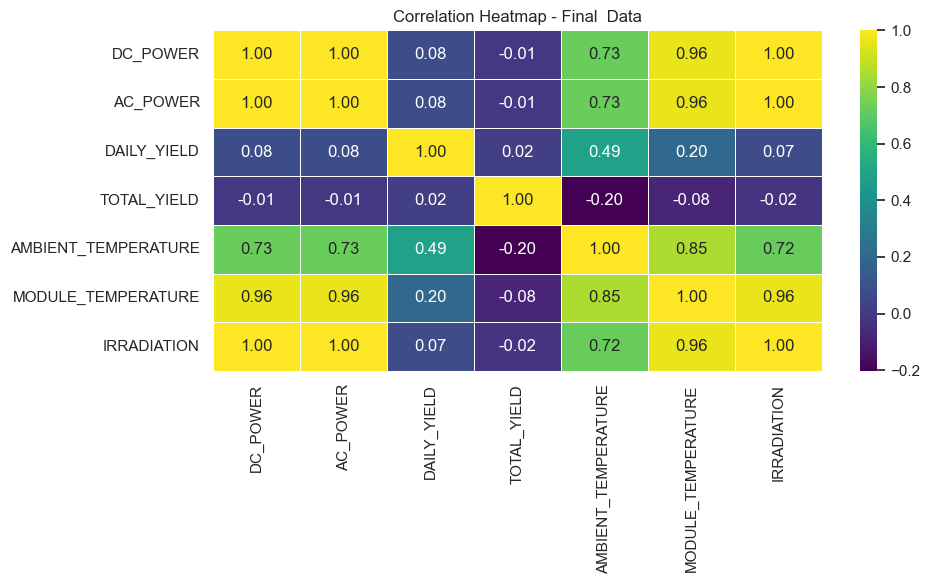

In [74]:
## Plotting heat map
plt.figure(figsize=(10, 6)) # sets the figure size as 10 inches width and 6 inches tall
sns.heatmap(correlation_matrix, annot=True, cmap="viridis", fmt=".2f", linewidths=0.5) 
plt.title("Correlation Heatmap - Final  Data")
plt.tight_layout() # used to prevent the overlapping in the figure area
plt.show() # used to visualize the figure


“From the above correlation heatmap we can clearly understand that the high correlations near 1+ shows that irradiation is the dominant factor
driving power production and module temperature. The Moderate positive correlations around 0.5 to 0.8 shows more energy produced on sunny days based on the  AMBIENT_TEMPERATURE with DC_POWER / AC_POWER and DAILY_YIELD. The weak (0) or negative (-) values shows no correlation and it's not statistically meaningful.”


In [75]:
Final_Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3157 entries, 2020-05-15 00:00:00 to 2020-06-17 23:45:00
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DC_POWER             3157 non-null   float64
 1   AC_POWER             3157 non-null   float64
 2   DAILY_YIELD          3157 non-null   float64
 3   TOTAL_YIELD          3157 non-null   float64
 4   AMBIENT_TEMPERATURE  3157 non-null   float64
 5   MODULE_TEMPERATURE   3157 non-null   float64
 6   IRRADIATION          3157 non-null   float64
dtypes: float64(7)
memory usage: 197.3 KB


### BOX PLOT
#### "bubble" shows the outlier,such that it shows diffrent behaviour from available data

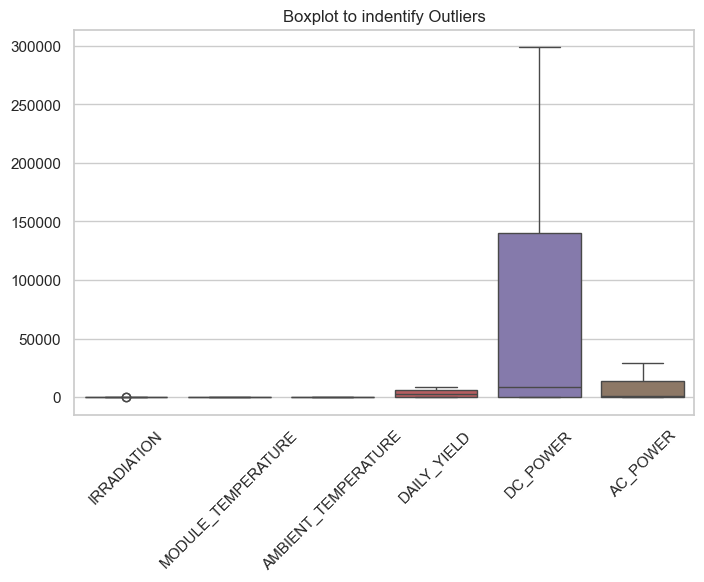

In [76]:
# Using these features to visualize the box plot to identify the outliers in a dataframe
Features = [
    'IRRADIATION',
    'MODULE_TEMPERATURE',
    'AMBIENT_TEMPERATURE',
    'DAILY_YIELD',
    'DC_POWER',
    'AC_POWER'
]
plt.figure(figsize=(8, 5))
sns.boxplot(data=Final_Data[Features])
plt.title("Boxplot to indentify Outliers")
plt.xticks(rotation=45)
plt.show()


### Applying the Interquartile range(IQR) method
#### to remove the outlier

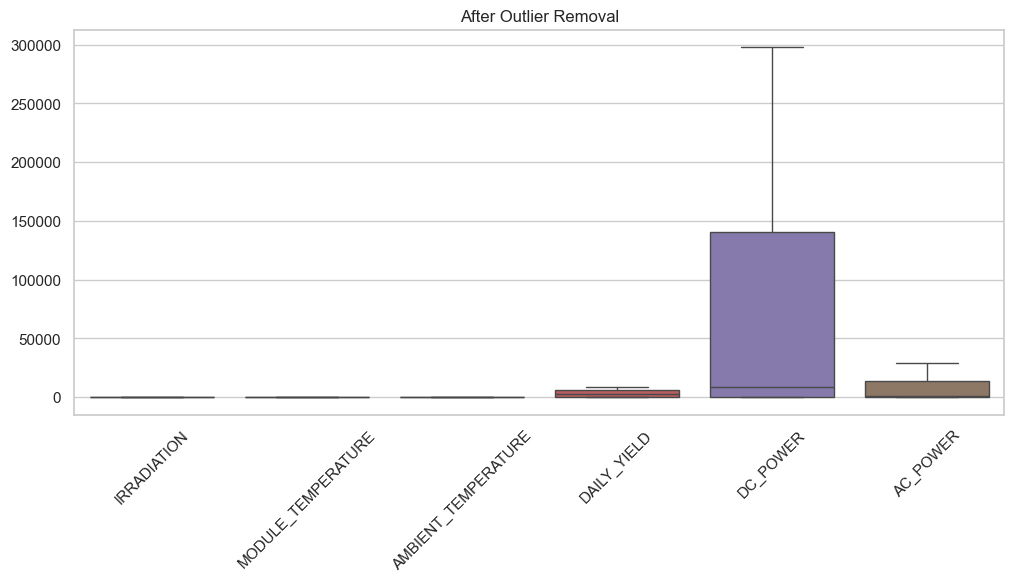

In [77]:
# creating a copy to avoid the changes in original data
Data_Clean = Final_Data.copy()


#applying IQR method to remove the outliers
for col in Features:
    Q1 = Data_Clean[col].quantile(0.25)
    Q3 = Data_Clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    Data_Clean = Data_Clean[(Data_Clean[col] >= lower_bound) & (Data_Clean[col] <= upper_bound)]


#Visualizing the box plot after removing the outliers
plt.figure(figsize=(12, 5))
sns.boxplot(data=Data_Clean[Features])
plt.title("After Outlier Removal")
plt.xticks(rotation=45)
plt.show()

### Feature Scaling

#### Standardization & Normalization

Feature scaling is a data preprocessing technique that transforms numerical features to a common scale or range, preventing features with larger values from unfairly dominating the model's learning process and ensuring all features contribute equally.

In [78]:
features_to_scale = [
    'IRRADIATION',
    'MODULE_TEMPERATURE',
    'AMBIENT_TEMPERATURE',
    'DAILY_YIELD',
    'DC_POWER',
    'AC_POWER' 
]
scaler = StandardScaler()
Final_Data_standardized = Final_Data.copy()
Final_Data_standardized[features_to_scale] = scaler.fit_transform(Final_Data[features_to_scale])

print(Final_Data_standardized.head())


                     DC_POWER  AC_POWER  DAILY_YIELD   TOTAL_YIELD  \
DATE_TIME                                                            
2020-05-15 00:00:00  -0.77872 -0.779373    -1.091826  6.837223e+06   
2020-05-15 00:15:00  -0.77872 -0.779373    -1.091826  6.837223e+06   
2020-05-15 00:30:00  -0.77872 -0.779373    -1.091826  6.837223e+06   
2020-05-15 00:45:00  -0.77872 -0.779373    -1.091826  6.837223e+06   
2020-05-15 01:00:00  -0.77872 -0.779373    -1.091826  6.852802e+06   

                     AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  
DATE_TIME                                                                  
2020-05-15 00:00:00            -0.112203           -0.677868    -0.763699  
2020-05-15 00:15:00            -0.141968           -0.685679    -0.763699  
2020-05-15 00:30:00            -0.186390           -0.699481    -0.763699  
2020-05-15 00:45:00            -0.213138           -0.718343    -0.763699  
2020-05-15 01:00:00            -0.280174           -0

### Feature Selection

In [79]:
features = ['IRRADIATION', 'MODULE_TEMPERATURE', 'AMBIENT_TEMPERATURE'] # Input features or Independant Features
target = 'DC_POWER' # Target Varibale or Dependent Variable

X = Final_Data_standardized[features]
y = Final_Data_standardized[target]


### Data Spliting

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

### Model Selection & Model building

In [81]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Model Testing

In [82]:
# Making predictions with the test data
y_pred = model.predict(X_test)
y_pred

array([-3.11374001e-01, -7.78720388e-01,  8.18701414e-01,  9.57426334e-01,
       -7.78720388e-01, -7.78720388e-01, -7.78720388e-01, -7.78720388e-01,
       -7.78720388e-01,  1.64225837e+00,  1.20239840e+00, -7.78720388e-01,
       -7.56166473e-01, -7.78720388e-01,  6.11486675e-01, -7.78720388e-01,
       -6.84822108e-01, -5.94711806e-01, -7.78720388e-01, -7.78720388e-01,
        6.51463890e-02, -7.78720388e-01,  1.29894993e+00, -7.78720388e-01,
       -2.60741688e-02,  1.48570425e-01, -7.78720388e-01,  2.32522897e+00,
       -7.51651721e-01, -3.87070288e-01,  9.55750527e-01, -2.93703755e-01,
        2.31014897e+00,  2.19061790e+00, -6.19978260e-01, -7.78720388e-01,
        8.09286986e-02, -7.78720388e-01, -7.42741764e-01, -7.78720388e-01,
       -7.78720388e-01, -7.78720388e-01, -7.78720388e-01,  5.60816763e-01,
       -7.78720388e-01, -6.51691570e-01,  9.33432435e-01, -7.78720388e-01,
        1.43306203e+00, -7.78720388e-01, -4.79174465e-01, -7.78720388e-01,
       -7.78720388e-01, -

### Applying Evaluation Metrics to check model's Performance

In [83]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R² Score:", r2)


MSE: 0.005932670070035871
R² Score: 0.9940892627603354


### Visualizing the Actual Value and the Predicted Value

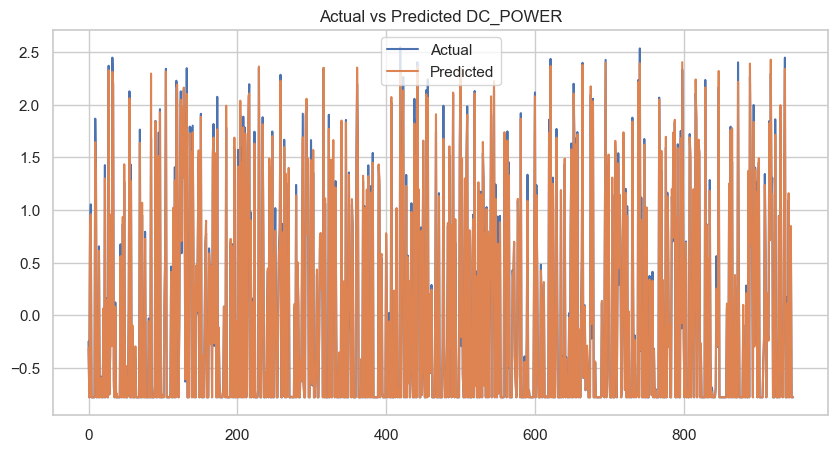

In [84]:

plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Actual vs Predicted DC_POWER")
plt.legend()
plt.show()


### Making Predictions of Solar Power Generation for the User's input

In [85]:
# features used in model training
features = ['IRRADIATION', 'MODULE_TEMPERATURE', 'AMBIENT_TEMPERATURE']

# user input
user_input = []
print("Enter values for the following features:")

for feature in features:
    value = float(input(f"{feature}: "))
    user_input.append(value)

# Reshape to match scaler input
input_array = np.array(user_input).reshape(1, -1)

# Scale using a new scaler trained only on those 3 features
scaler = StandardScaler().fit(X_train)  
scaled_input = scaler.transform(input_array)

# Predict
predicted_power = model.predict(scaled_input)

print(f"\n⚡ Predicted DC Power: {predicted_power[0]:.4f}")


Enter values for the following features:

⚡ Predicted DC Power: 2.3362


c:\Users\vaide\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\vaide\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [88]:
###solar power generation

# Extract temporal features from DATE_TIME index
Final_Data_with_features = Final_Data.copy()
Final_Data_with_features['HOUR'] = Final_Data_with_features.index.hour
Final_Data_with_features['DAY'] = Final_Data_with_features.index.day
Final_Data_with_features['MONTH'] = Final_Data_with_features.index.month
Final_Data_with_features['DAY_OF_WEEK'] = Final_Data_with_features.index.dayofweek

features = [
    'IRRADIATION',
    'MODULE_TEMPERATURE',
    'AMBIENT_TEMPERATURE',
    'HOUR',
    'DAY',
    'MONTH',
    'DAY_OF_WEEK'
]
target = 'DC_POWER'

X = Final_Data_with_features[features]
y = Final_Data_with_features[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
y_pred


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R² Score:", r2)


#getting the input from the user
date_str = input("Enter date and time (YYYY-MM-DD HH:MM): ")
IRRADIATION = float(input("Enter IRRADIATION: "))
MODULE_TEMPERATURE = float(input("Enter MODULE TEMPERATURE (°C): "))
AMBIENT_TEMPERATURE = float(input("Enter AMBIENT TEMPERATURE (°C): "))

#parsing Date time and Extracting the input features
input_time = datetime.strptime(date_str, "%Y-%m-%d %H:%M")
hour = input_time.hour
day = input_time.day
month = input_time.month
day_of_week = input_time.weekday() 

#creating Input Data Frame
input_df = pd.DataFrame([[ IRRADIATION, MODULE_TEMPERATURE, AMBIENT_TEMPERATURE, hour, day, month, day_of_week]],
            columns=['IRRADIATION','MODULE_TEMPERATURE','AMBIENT_TEMPERATURE','HOUR','DAY','MONTH','DAY_OF_WEEK'])

#Scaling the user input
input_scaled = scaler.transform(input_df)

#making prediction with trained model
predicted_dc_power = model.predict(input_scaled)

#printing the predicted result
print(f"\n⚡ Predicted DC Power: {predicted_dc_power[0]:.4f}")


MSE: 29206326.40528195
R² Score: 0.9960605825692409

⚡ Predicted DC Power: 275163.5140


### Saving the Model using JobLib

In [89]:
joblib.dump(model, 'solar_Power_generation_model.pkl')

['solar_Power_generation_model.pkl']

# RANDOM FOREST
